Deep Learning
=============

Assignment 5
------------

The goal of this assignment is to train a Word2Vec skip-gram model over [Text8](http://mattmahoney.net/dc/textdata) data.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
%matplotlib inline
from __future__ import print_function
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import zipfile
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE
import time

Download the data from the source website if necessary.

In [2]:
url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
  """Download a file if not present, and make sure it's the right size."""
  if not os.path.exists(filename):
    filename, _ = urlretrieve(url + filename, filename)
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified %s' % filename)
  else:
    print(statinfo.st_size)
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

filename = maybe_download('text8.zip', 31344016)

Found and verified text8.zip


Read the data into a string.

In [3]:
def read_data(filename):
  """Extract the first file enclosed in a zip file as a list of words"""
  with zipfile.ZipFile(filename) as f:
    data = tf.compat.as_str(f.read(f.namelist()[0])).split()
    print("Number of files in the zip:", len(f.namelist()))
  return data
  
words = read_data(filename)
print('Data size %d\n' % len(words))
print(words[0:100])

Number of files in the zip: 1
Data size 17005207

['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working', 'class', 'radicals', 'including', 'the', 'diggers', 'of', 'the', 'english', 'revolution', 'and', 'the', 'sans', 'culottes', 'of', 'the', 'french', 'revolution', 'whilst', 'the', 'term', 'is', 'still', 'used', 'in', 'a', 'pejorative', 'way', 'to', 'describe', 'any', 'act', 'that', 'used', 'violent', 'means', 'to', 'destroy', 'the', 'organization', 'of', 'society', 'it', 'has', 'also', 'been', 'taken', 'up', 'as', 'a', 'positive', 'label', 'by', 'self', 'defined', 'anarchists', 'the', 'word', 'anarchism', 'is', 'derived', 'from', 'the', 'greek', 'without', 'archons', 'ruler', 'chief', 'king', 'anarchism', 'as', 'a', 'political', 'philosophy', 'is', 'the', 'belief', 'that', 'rulers', 'are', 'unnecessary', 'and', 'should', 'be', 'abolished', 'although', 'there', 'are', 'differing']


Build the dictionary and replace rare words with UNK token.

In [4]:
vocabulary_size = 50000

def build_dataset(words):
  count = [['UNK', -1]]
  # count is a list of word and count pairs. 'count' is number of times that its corresponding word 
  # appears in the text. The first one being 'UNK'. 
  # Only the 50000 mostly used words are added to count.
  count.extend(collections.Counter(words).most_common(vocabulary_size - 1))  
  dictionary = dict()
  # disctionary is indexed by each word. Its value is the number of the word.
  for word, _ in count:
    dictionary[word] = len(dictionary) # Each word is assigned a unique value (increases as dictionary grows, starting at 1)
  data = list()  # data shall be the text expressed with the unique value assigned above (index value below)
  unk_count = 0
  for word in words:
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0  # dictionary['UNK']
      unk_count = unk_count + 1
    data.append(index)
  count[0][1] = unk_count
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
  return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)  # 'data' is text represented with index in dictionary
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10])
print('value of the :', dictionary['the'])
print('value of of  :', dictionary['of'])
print('value of as  :', dictionary['as'])
print('value of term:', dictionary['term'])
del words  # Hint to reduce memory.

Most common words (+UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data [5242, 3081, 12, 6, 195, 2, 3134, 46, 59, 156]
value of the : 1
value of of  : 2
value of as  : 12
value of term: 195


Function to generate a training batch for the skip-gram model.

In the skip-gram model, the distributed representation of the input word is used to predict the context (words that surrond the input word).

generate_batch() function below returns batch and lables based on the following inputs:
* data, and data_index : global text and index to the text
* batch_size: Learning batch size of stochastic gradient descent training
* num_skips: How many times to reuse an input to generate a label. In other words, how many blocks the batch_size input data should be divided into. batch_size % num_skips must be 0 
* skip_window: How many words to consider left and right. In other words, number of wrods that are to be predicted on each side of the input word.

I think **num_skip should be double of skip_window** in order to generate labels around input word.

generate_batch() function outputs:
* batch: input data for stochastic gradient descent training. It is divided into batch_size/num_skips blocks each of which has a size of 2*skip_window. Each block contains the input word which is the middle of a span in text (span size is 2 * skip_window + 1, [ skip_window target skip_window ])
* labels: words that are to be predicted by the input word. It is also divided into batch_size/num_skips blocks each of which has a size of 2*skip_window. Each block contains randomly ordered words that surround the input word.


In [5]:
data_index = 0

def generate_batch(batch_size, num_skips, skip_window):
  global data_index
  assert batch_size % num_skips == 0
  assert num_skips <= 2 * skip_window
  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  for ll in range(batch_size): 
    batch[ll] = 0 
    labels[ll,0] = 0
  span = 2 * skip_window + 1 # [ skip_window target skip_window ]
  buffer = collections.deque(maxlen=span)  # list-like container with fast appends and pops on either end
  # 'buffer' contains continous block 'data' text. Size is 2*skip_window+1 # [ skip_window target skip_window ]   
  for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  #print('\nbuffer: ', [reverse_dictionary[bb] for bb in buffer])
  for i in range(batch_size // num_skips):
    target = skip_window  # target label at the center of the buffer
    targets_to_avoid = [ skip_window ]
    #print('target: ', target)
    #print('targets_to_avoid: ', targets_to_avoid)
    for j in range(num_skips):
      while target in targets_to_avoid:
        target = random.randint(0, span - 1) # Find a random number which is not in targets_to_avoid
      targets_to_avoid.append(target)
      #print('targets_to_avoid 2: ', targets_to_avoid)
      batch[i * num_skips + j] = buffer[skip_window]
      labels[i * num_skips + j, 0] = buffer[target]
      #print('    batch:', [reverse_dictionary[bbb] for bbb in batch])
      #print('    labels:', [reverse_dictionary[lll] for lll in labels.reshape(8)])
    buffer.append(data[data_index])  # Next text is psushed to buffer but the first one is moved out. 
    #print('\nbuffer: ', [reverse_dictionary[bb] for bb in buffer])
    data_index = (data_index + 1) % len(data)
  return batch, labels

print('data:', [reverse_dictionary[di] for di in data[:8]])

for num_skips, skip_window in [(2, 1), (4, 2)]:
    print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
    data_index = 0
    batch, labels = generate_batch(batch_size=8, num_skips=num_skips, skip_window=skip_window)
    print('    batch:', [reverse_dictionary[br1] for br1 in batch])
    print('    labels:', [reverse_dictionary[br2] for br2 in labels.reshape(8)])

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first']

with num_skips = 2 and skip_window = 1:
    batch: ['originated', 'originated', 'as', 'as', 'a', 'a', 'term', 'term']
    labels: ['as', 'anarchism', 'originated', 'a', 'as', 'term', 'of', 'a']

with num_skips = 4 and skip_window = 2:
    batch: ['as', 'as', 'as', 'as', 'a', 'a', 'a', 'a']
    labels: ['term', 'a', 'anarchism', 'originated', 'originated', 'as', 'term', 'of']


Train a skip-gram model.

In [6]:
batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
skip_window = 1 # How many words to consider left and right.
num_skips = 2 # How many times to reuse an input to generate a label.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

  # Input data.
  train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
  train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
  # Variables.
  embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
  softmax_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)))
  softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
  # Model.
  # Look up embeddings for inputs.
  # embedding_lookup() function retrieves rows of the params tensor. 
  # The behavior is similar to using indexing with arrays in numpy.
  # Thus result of embedding_lookup() is a dimension (batch_size, embedding_size) tensor in this call.
  embed = tf.nn.embedding_lookup(embeddings, train_dataset)
  # Compute the softmax loss, using a sample of the negative labels each time.
  loss = tf.reduce_mean(
    tf.nn.sampled_softmax_loss(softmax_weights, softmax_biases, 
                               labels=train_labels, inputs=embed, num_sampled=num_sampled, num_classes=vocabulary_size))

  # Optimizer.
  # Note: The optimizer will optimize the softmax_weights AND the embeddings.
  # This is because the embeddings are defined as a variable quantity and the
  # optimizer's `minimize` method will by default modify all variable quantities 
  # that contribute to the tensor it is passed.
  # See docs on `tf.train.Optimizer.minimize()` for more details.
  optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
  
  # Compute the similarity between minibatch examples and all embeddings.
  # We use the cosine distance:
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(
    normalized_embeddings, valid_dataset)
  similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

In [7]:
num_steps = 100001
start_time = time.time()
with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  average_loss = 0
  for step in range(num_steps):
    batch_data, batch_labels = generate_batch(
      batch_size, num_skips, skip_window)
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, l = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += l
    if step % 2000 == 0:
      if step > 0:
        average_loss = average_loss / 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step %d: %f Time elapsed:%.1f' % (step, average_loss, time.time()-start_time))
      average_loss = 0
    # note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
      sim = similarity.eval()
      for i in range(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8 # number of nearest neighbors
        # argsort() returns the indices that would sort an array.
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log = 'Nearest to %s:' % valid_word
        for k in range(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log = '%s %s,' % (log, close_word)
        print(log)
  final_embeddings = normalized_embeddings.eval()
print('\n')
#print("embedding shape:\t", final_embeddings.type())
print("embedding shape:\t", final_embeddings.shape)
print("valid_embeddings shape:\t", valid_embeddings.shape)
print("sim shape:\t\t", sim.shape)

print("Time it takes to run the graph with %d:" % num_steps, time.time()-start_time)

Initialized
Average loss at step 0: 8.001504 Time elapsed:0.5
Nearest to b: turin, marred, boulton, digit, gadgets, yield, alberoni, shrubs,
Nearest to i: addams, parkway, outlook, fructose, operas, acrobatic, pubns, meditator,
Nearest to first: paleolithic, roommate, grohl, connotations, beating, locates, tolson, locarno,
Nearest to over: yeah, conceive, ravens, withers, jamal, bites, liberalize, honourable,
Nearest to so: mares, ubiquity, grande, fined, werth, vanderbilt, thrive, hailstones,
Nearest to the: sole, decomposes, ethanol, idols, threshold, gzip, abridgment, eccentric,
Nearest to which: eubacteria, mazes, maryam, lavoisier, slum, ufc, stratford, buccaneers,
Nearest to with: selena, eritreans, sequentially, potatoes, apap, theoretic, flax, appleton,
Nearest to nine: aragonese, revolutionary, copernicus, drawers, inactivity, latitudes, tiles, dun,
Nearest to only: schedules, borland, parishes, endorses, ridiculed, reassure, avenue, gantry,
Nearest to will: pregnant, lyapunov

In [15]:
num_points = 400

# t-SNE [1] is a tool to visualize high-dimensional data. It converts similarities between 
# data points to joint probabilities and tries to minimize the Kullback-Leibler divergence 
# between the joint probabilities of the low-dimensional embedding and the high-dimensional data.
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

print("final_embeddings:\t", final_embeddings.shape)
print("two_d_embeddings:\t", two_d_embeddings.shape)

print('final_embeddings[1675]:\t%s\n' % reverse_dictionary[1675], final_embeddings[1675, :])

final_embeddings:	 (50000, 128)
two_d_embeddings:	 (400, 2)
final_embeddings[1675]:	thousands
 [ 0.1253005  -0.03949144  0.03606576 -0.10401853  0.01169183  0.11822291
  0.1315708   0.06176968 -0.01356553  0.00136624  0.05520301  0.09356604
 -0.14368695  0.02466403 -0.01787057 -0.00972723 -0.12453368 -0.00858913
  0.01577335  0.01966513 -0.05197255 -0.09312995  0.09626154  0.02849921
 -0.03005531 -0.02988689 -0.06496565 -0.07391757  0.08502205  0.1564616
  0.09523626 -0.06520877 -0.04963104 -0.02112453 -0.07563873 -0.08999566
 -0.1358211  -0.10772789  0.03139108  0.17363289 -0.10195959  0.08078897
  0.07584289 -0.11745198 -0.03179434  0.01155001 -0.05004957  0.06725944
 -0.03078083  0.17711519  0.06189831  0.05689853 -0.14040382  0.15414898
 -0.06433661 -0.06325899  0.03631936 -0.03775759 -0.18249024  0.08998876
  0.15212122  0.02564189 -0.0304166  -0.07110141 -0.03555027 -0.01310779
  0.06524435  0.1200058  -0.02046573  0.05268716  0.10685097  0.11582364
  0.09250194  0.00294346  0.15

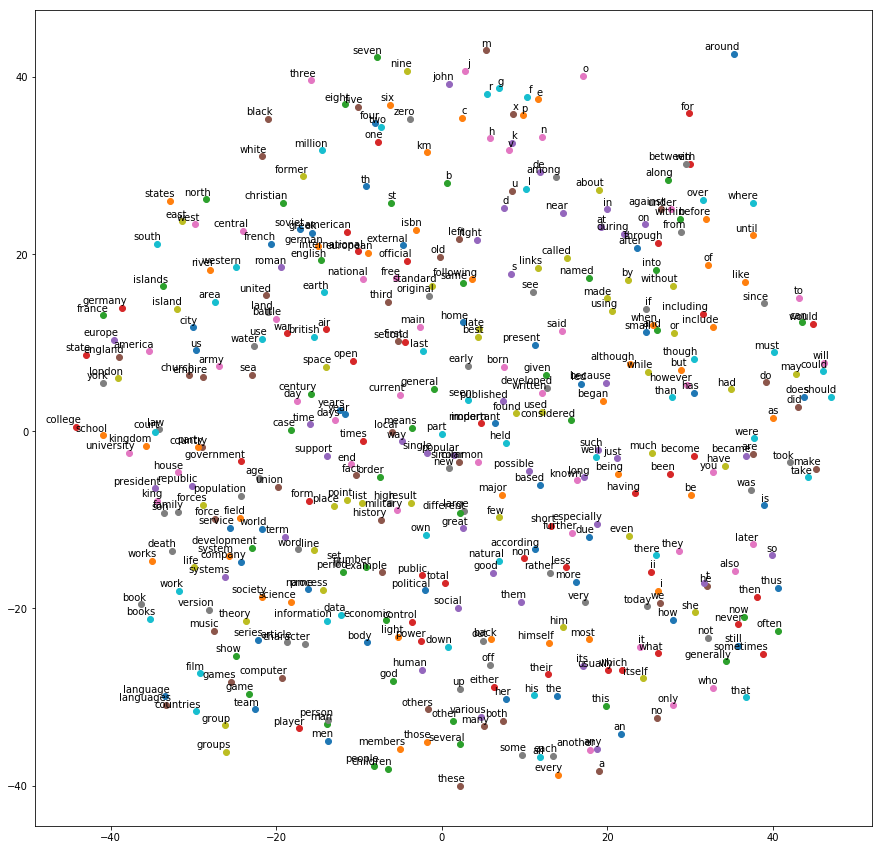

In [9]:
def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)

---

Problem
-------

An alternative to skip-gram is another Word2Vec model called [CBOW](http://arxiv.org/abs/1301.3781) (Continuous Bag of Words). In the CBOW model, instead of predicting a context word from a word vector, you predict a word from the sum of all the word vectors in its context. Implement and evaluate a CBOW model trained on the text8 dataset.

---

## About CBOW model implementation
With regards to training with skip-gram model or CBOW model, the only difference is the way training data (batches and labels) are generated. Once generate_batch() function is modified to generate batch and labels with CBOW model, the rest of the embedding training algorithm can be fully reused. 

However in the following implementation, a different loss calculation algorithm nce_loss is used to replace sampled_softmax_loss algorithm above. 

In [10]:
# generate_CBOW_batch() code in this block is copied from skip-gram model code.
# Only two lines of code are modified as difference of the two models are just switching of sample and label

data_index = 0

def generate_CBOW_batch(batch_size, num_skips, skip_window):
  global data_index
  assert batch_size % num_skips == 0
  assert num_skips <= 2 * skip_window
  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  for ll in range(batch_size): 
    batch[ll] = 0 
    labels[ll,0] = 0
  span = 2 * skip_window + 1 # [ skip_window target skip_window ]
  buffer = collections.deque(maxlen=span)  # list-like container with fast appends and pops on either end
  # 'buffer' contains continous block 'data' text. Size is 2*skip_window+1 # [ skip_window target skip_window ]   
  for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  #print('\nbuffer: ', [reverse_dictionary[bb] for bb in buffer])
  for i in range(batch_size // num_skips):
    target = skip_window  # target label at the center of the buffer
    targets_to_avoid = [ skip_window ]
    #print('target: ', target)
    #print('targets_to_avoid: ', targets_to_avoid)
    for j in range(num_skips):
      while target in targets_to_avoid:
        target = random.randint(0, span - 1) # Find a random number which is not in targets_to_avoid
      targets_to_avoid.append(target)
      #print('targets_to_avoid 2: ', targets_to_avoid)
      batch[i * num_skips + j] = buffer[skip_window] # sample and label are swtiched compared with skip-gram model
      labels[i * num_skips + j, 0] = buffer[target]
      #print('    batch:', [reverse_dictionary[bbb] for bbb in batch])
      #print('    labels:', [reverse_dictionary[lll] for lll in labels.reshape(8)])
    buffer.append(data[data_index])  # Next text is psushed to buffer but the first one is moved out. 
    #print('\nbuffer: ', [reverse_dictionary[bb] for bb in buffer])
    data_index = (data_index + 1) % len(data)
  return batch, labels

print('data:', [reverse_dictionary[di] for di in data[:8]])

for num_skips, skip_window in [(2, 1), (4, 2)]:
#for num_skips, skip_window in [(2, 1)]:
    #print('\n\n\n')
    print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
    data_index = 0
    batch, labels = generate_batch(batch_size=8, num_skips=num_skips, skip_window=skip_window)
    print('    batch:', [reverse_dictionary[br1] for br1 in batch])
    print('    labels:', [reverse_dictionary[br2] for br2 in labels.reshape(8)])

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first']

with num_skips = 2 and skip_window = 1:
    batch: ['originated', 'originated', 'as', 'as', 'a', 'a', 'term', 'term']
    labels: ['as', 'anarchism', 'a', 'originated', 'as', 'term', 'a', 'of']

with num_skips = 4 and skip_window = 2:
    batch: ['as', 'as', 'as', 'as', 'a', 'a', 'a', 'a']
    labels: ['anarchism', 'originated', 'a', 'term', 'as', 'originated', 'of', 'term']


In [11]:
num_steps = 100001
start_time = time.time()
with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  average_loss = 0
  for step in range(num_steps):
    batch_data, batch_labels = generate_CBOW_batch(
      batch_size, num_skips, skip_window)
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, l = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += l
    if step % 2000 == 0:
      if step > 0:
        average_loss = average_loss / 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step %d: %f Time elapsed:%.1f' % (step, average_loss, time.time()-start_time))
      average_loss = 0
    # note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
      sim = similarity.eval()
      for i in range(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8 # number of nearest neighbors
        # argsort() returns the indices that would sort an array.
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log = 'Nearest to %s:' % valid_word
        for k in range(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log = '%s %s,' % (log, close_word)
        print(log)
  final_embeddings = normalized_embeddings.eval()
print('\n')
#print("embedding shape:\t", final_embeddings.type())
print("embedding shape:\t", final_embeddings.shape)
print("valid_embeddings shape:\t", valid_embeddings.shape)
print("sim shape:\t\t", sim.shape)

print("Time it takes to run the graph with %d:" % num_steps, time.time()-start_time)

Initialized
Average loss at step 0: 8.334836 Time elapsed:0.1
Nearest to b: pelt, pda, google, fianc, webmineral, thousandth, carbohydrates, implementing,
Nearest to i: sarin, carnot, booths, booty, cyclone, tribunals, glossaries, orange,
Nearest to first: secularism, oriole, sensual, tips, explaining, octagonal, laced, contrapuntal,
Nearest to over: ivoire, arousing, killing, ecs, harmon, refueling, bloodstream, introns,
Nearest to so: extant, cronquist, microprogramming, dative, kuro, doubleheader, za, theodoric,
Nearest to the: singleton, nursultan, huddersfield, belgrade, hideous, epicurus, montane, sara,
Nearest to which: tragedy, dogmatic, diuretic, confessing, virtue, adapts, discretionary, aux,
Nearest to with: aykroyd, jains, entourage, traction, sifre, screen, lethbridge, albanians,
Nearest to nine: magnified, xn, heaviside, langevin, transfusions, doppler, poids, arcades,
Nearest to only: wallets, howard, bethany, pubns, incontinence, roach, microcebus, topless,
Nearest to w